In [1]:
!pip install -U spacy
!python -m spacy download en_core_web_md

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [2]:
# Importing Required Libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import spacy
import en_core_web_md
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)

import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Importing Dataset
train_set_link = 'https://raw.githubusercontent.com/HardiRathod/news-topic-classification/master/BBC%20News%20Train.csv'
test_set_link = 'https://raw.githubusercontent.com/HardiRathod/news-topic-classification/master/BBC%20News%20Test.csv'
df_train = pd.read_csv(train_set_link)
df_test = pd.read_csv(test_set_link)

In [4]:
# Encoding Categories
df_train['Category_id'] = df_train['Category'].factorize()[0]
colslist = ['Index', 'News', 'Type', 'Category_id']
df_train.columns = colslist

df_train.sample(5, random_state=0)

,Index,News,Type,Category_id
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,4
354,1349,tory candidate quits over remark a conservativ...,politics,2
1227,1572,bath faced with tindall ultimatum mike tindall...,sport,3
907,1155,chancellor rallies labour voters gordon brown ...,politics,2
575,307,young debut cut short by ginepri fifteen-year-...,sport,3


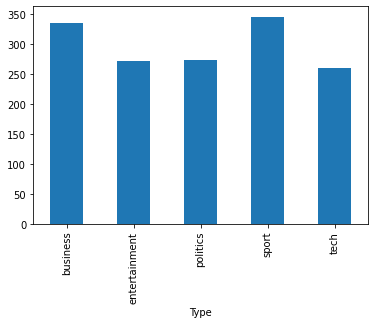

In [5]:
# Visualizing the frequency of different types of articles
df_train.groupby('Type').Index.count().plot.bar(ylim=0)

In [6]:
# Removing Stopwords
df_train['News'] = df_train['News'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [7]:
# Stemming the words
ps = PorterStemmer()
df_train['News'] = df_train['News'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))
# Lemmatizing the words
df_train['News'] = df_train['News'].apply(lambda x: ' '.join([x.lemma_ if x.lemma_ != '-PRON-' else x.text for x in nlp(x)]))

In [8]:
# Converting text to lowercase
df_train['News'] = df_train['News'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
# Removing punctuations
df_train['News'] = df_train['News'].str.replace('[^\w\s]','')

# Removing words which have frequency of occurence lower than 3
freq = pd.Series(' '.join(df_train['News']).split()).value_counts()
freq = freq[freq <= 3]
freq = list(freq.index.values)
df_train['News'] = df_train['News'].apply(lambda x: ' '.join([word for word in x.split() if word not in (freq)]))
df_train = df_train[['Index', 'Type', 'Category_id', 'News']]

In [9]:
# Applying TF-IDF Vectorization to the data
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
features = tfidf.fit_transform(df_train.News).toarray()
labels = df_train.Category_id

In [10]:
df_train.columns = ['Index', 'Type', 'Category_id', 'News']

# Generating Category to ID dictionary
category_id_df = df_train[['Type', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_df.values)
# Generating ID to Category dictionary
id_to_category = dict(category_id_df[['Category_id', 'Type']].values)

In [11]:
# Finding the most correlated terms within each category using chi2 analysis
N = 3
for Type, Category_id in sorted(category_to_id.items()):
    # Extracting the features
    features_chi2 = chi2(features, labels == Category_id)
    # Sorting the indices of each feature
    indices = np.argsort(features_chi2[0])
    # Converts indices to feature names
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # List of single word features i.e. Unigrams
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # List of double word features i.e. Bigrams
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("# '{}':".format(Type))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'business':
  . Most correlated unigrams:
       . profit
       . growth
       . bank
  . Most correlated bigrams:
       . stock market
       . interest rate
       . analyst say
# 'entertainment':
  . Most correlated unigrams:
       . actor
       . star
       . film
  . Most correlated bigrams:
       . good film
       . lo angel
       . box offic
# 'politics':
  . Most correlated unigrams:
       . blair
       . tori
       . labour
  . Most correlated bigrams:
       . lib dem
       . toni blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . cup
       . match
       . champion
  . Most correlated bigrams:
       . grand slam
       . australian open
       . six nation
# 'tech':
  . Most correlated unigrams:
       . softwar
       . comput
       . user
  . Most correlated bigrams:
       . anti viru
       . let peopl
       . mobil phone


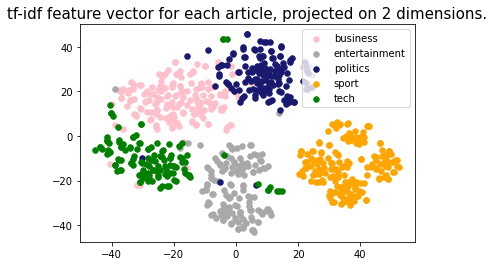

In [12]:
# Sampling a random subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.5)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)

# Projecting in two dimensions
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Plotting the data
for Category, Category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == Category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[Category_id], label=Category)

plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

In [13]:
# Considering 4 different models Random Forest, Naive Bayes, Support Vector Classifier and Logistic Regression
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(C=0.1, kernel='linear')
]
# Applying Cross Validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
# Iterating over different models considering accuracy as metric
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

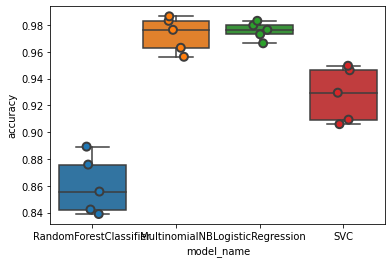

In [14]:
# Visualising the accuracy of different models
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,size=8, jitter=True, edgecolor="gray", linewidth=2)

In [15]:
# Analysing the accuracy of different models
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.975839
MultinomialNB             0.973154
RandomForestClassifier    0.860403
SVC                       0.928188
Name: accuracy, dtype: float64

In [16]:
# Applying the best model i.e. Logistic Regression
model = LogisticRegression(random_state=0)
# Splitting the data into training and validation data
X_train, X_valid, y_train, y_valid, indices_train, indices_valid = train_test_split(features, labels, df_train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_valid)
y_pred = model.predict(X_valid)

Text(0.5, 15.0, 'Predicted')

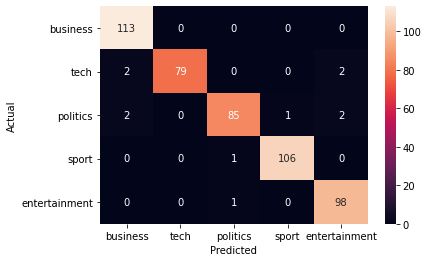

In [17]:
# Creating the confusion matrix
conf_mat = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Type.values, yticklabels=category_id_df.Type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [18]:
# Applying the model on entire training data
model.fit(features, labels)
# Viewing the most correlated words
N = 5
for Type, Category_id in sorted(category_to_id.items()):
    # Sorting the indices
    indices = np.argsort(model.coef_[Category_id])
    # Converting indices into feature names
    feature_names = np.array(tfidf.get_feature_names())[indices]
    # List of single word features i.e. Unigrams
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    # List of double word features i.e. Bigrams
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]

    print("# '{}':".format(Type))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . firm
       . compani
       . bank
       . market
       . econom
  . Top bigrams:
       . chief execut
       . analyst say
       . last year
       . stock market
       . interest rate
# 'entertainment':
  . Top unigrams:
       . film
       . star
       . music
       . award
       . singer
  . Top bigrams:
       . box offic
       . lo angel
       . number one
       . tv show
       . film mak
# 'politics':
  . Top unigrams:
       . labour
       . parti
       . mr
       . minist
       . blair
  . Top bigrams:
       . mr blair
       . toni blair
       . prime minist
       . mr brown
       . lib dem
# 'sport':
  . Top unigrams:
       . win
       . match
       . player
       . champion
       . game
  . Top bigrams:
       . six nation
       . australian open
       . grand slam
       . world cup
       . bbc sport
# 'tech':
  . Top unigrams:
       . user
       . comput
       . use
       . technolog
       . softw

In [21]:
# Applying the model to test data and predicting categories
colslist = ['Index', 'News']
df_test.columns = colslist
ids = df_test.Index.tolist()
texts = df_test.News.tolist()
test_features = tfidf.transform(texts)
prediction = model.predict(test_features)
predictions = []
for text, predicted in zip(texts, prediction):
    predictions.append(id_to_category[predicted])

data = {'Index': ids, 'Category': predictions}
df_final = pd.DataFrame(data, columns = ['Index', 'Category'])
df_final.to_csv('submission.csv', index=False, encoding='utf-8')
df_final

,Index,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,sport
733,206,business
